In [1]:
import sys
sys.path.append("ml")

In [2]:
import time
import json
import glob
import random
import numpy as np
import torch
import make_dataset2 as make_dataset

In [3]:
random.seed(1234)

In [4]:
device = "cpu"

In [5]:
class EWMA:
    def __init__(self, alpha=0.02):
        self.alpha = alpha
        self.value = None

    def apply(self, x):
        self.value = x if self.value is None else (1 - self.alpha) * self.value + self.alpha * x

In [6]:
%%time

def load_games(games):
    features, policy, value = make_dataset.process_game_paths(games)

    # Project down to just the duck moves
    #is_duck_move = features[:, 14, 0, 0] == 1
    dm_features = features#[is_duck_move]
    dm_policy = policy#[is_duck_move]

    # Our features are, in order:
    # A Six channels for our pieces: pawns, knights, bishops, rooks, queens, kings
    # A Six channels for their pieces.
    # A One channel for ducks.
    # 1 One channel that's all ones if it's white to move, zeros otherwise.
    # 0 One channel for if it's the duck subturn.
    # 1 Two channels for our castling rights: king side, queen side
    # 1 Two channels for their castling rights.
    # A One channel for an en passant square.
    # A Pairs of (from, to) channels for the history of moves.
    # 0 One channel of all ones.

    all_layer_indices = (
        0, 1, 2, 3,  4,  5, # Our pieces
        6, 7, 8, 9, 10, 11, # Their pieces
        12, # Ducks
        14, # Is duck subturn -- too many features
        19, # En passant
        20, 21, 22, 23, 24, 25, 26, 27, # Past moves
    )
    all_layers = dm_features[:, all_layer_indices, :, :]

    # Flatten features.
    dm_features = all_layers.reshape((-1, 23 * 8 * 8))
    # Find the move indices.
    dm_policy = dm_policy.reshape((-1, 64 * 64)).argmax(axis=-1)
    # Get just the destination square by taking %64.
    dm_policy = dm_policy % 64
    return dm_features, dm_policy

dm_features, dm_policy = load_games(random.sample(glob.glob("games/*.json"), 32))
dm_val_features, dm_val_policy = load_games(glob.glob("val-games/*.json"))
dm_val_features = torch.tensor(dm_val_features, dtype=torch.float32, device=device)
dm_val_policy = torch.tensor(dm_val_policy, dtype=torch.int64, device=device)

print(dm_features.shape, dm_policy.shape)
print(dm_val_features.shape, dm_val_policy.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.54it/s]


Total games: 21132
Total moves: 2279876
Total storage: 21855.65333557129 MiB


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1239.88it/s]


Total games: 148
Total moves: 21997
Total storage: 210.8705940246582 MiB


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 442.97it/s]


(2279876, 1472) (2279876,)
torch.Size([21997, 1472]) torch.Size([21997])
CPU times: user 1min 29s, sys: 6.95 s, total: 1min 36s
Wall time: 2min 19s


In [23]:
feature_count = dm_features.shape[1]
model = torch.nn.Sequential(
    torch.nn.Linear(feature_count, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 64),
).to(device)
print("Parameters:", sum(np.product(t.shape) for t in model.parameters()))

Parameters: 49248


In [24]:
cross_en = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
loss_ewma = EWMA()

In [25]:
def make_batch(batch_size):
    indices = np.random.randint(0, len(dm_features), size=batch_size)
    features = torch.tensor(dm_features[indices], dtype=torch.float32, device=device)
    policy = torch.tensor(dm_policy[indices], dtype=torch.int64, device=device)
    return features, policy

start_time = time.time()
for i in range(1_000_000):
    optimizer.zero_grad()
    features, target_policy = make_batch(512)
    policy_output = model(features)
    loss = cross_en(policy_output, target_policy)
    loss.backward()
    optimizer.step()
    loss_ewma.apply(loss.item())

    if i % 2500 == 0:
        # Compute the accuracy.
        outputs = model(dm_val_features)
        correct = outputs.argmax(axis=-1) == dm_val_policy
        accuracy = correct.mean(dtype=torch.float32).item()
        print("(%7.1f) [%7i] loss = %.4f (val acc: %5.1f%%)" % (
            time.time() - start_time, i, loss_ewma.value, 100 * accuracy,
        ))

(    0.0) [      0] loss = 4.1414 (val acc:   1.2%)
(    3.1) [   2500] loss = 3.3144 (val acc:  21.1%)
(    6.1) [   5000] loss = 3.1596 (val acc:  23.7%)
(    9.1) [   7500] loss = 3.1124 (val acc:  25.0%)
(   12.1) [  10000] loss = 3.0769 (val acc:  25.5%)
(   15.2) [  12500] loss = 3.0412 (val acc:  25.6%)
(   18.3) [  15000] loss = 3.0404 (val acc:  25.8%)
(   21.4) [  17500] loss = 3.0351 (val acc:  26.0%)
(   24.4) [  20000] loss = 3.0309 (val acc:  25.9%)
(   27.4) [  22500] loss = 3.0093 (val acc:  25.9%)
(   30.4) [  25000] loss = 3.0130 (val acc:  26.1%)
(   33.5) [  27500] loss = 3.0053 (val acc:  26.4%)
(   36.6) [  30000] loss = 3.0053 (val acc:  26.6%)
(   39.6) [  32500] loss = 3.0138 (val acc:  26.5%)
(   42.6) [  35000] loss = 3.0075 (val acc:  26.6%)
(   45.6) [  37500] loss = 2.9886 (val acc:  26.6%)
(   48.6) [  40000] loss = 2.9923 (val acc:  26.7%)
(   51.6) [  42500] loss = 2.9962 (val acc:  26.9%)
(   54.7) [  45000] loss = 2.9992 (val acc:  26.8%)
(   57.7) [ 

KeyboardInterrupt: 

In [26]:
torch.save(model.state_dict(), "move_model.pt")

In [29]:
for k, v in model.state_dict().items():
    print(k, v.shape)

0.weight torch.Size([32, 1472])
0.bias torch.Size([32])
2.weight torch.Size([64, 32])
2.bias torch.Size([64])


In [32]:
W = model.state_dict()["0.weight"].detach().cpu().numpy()

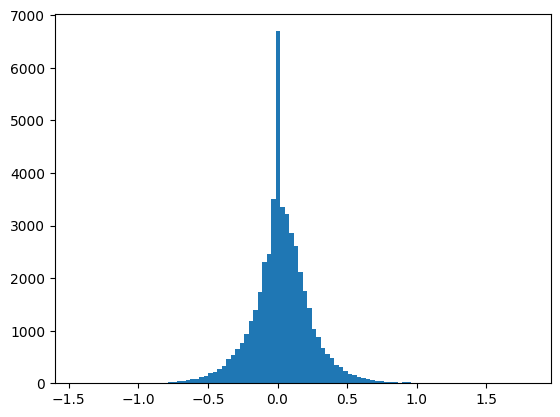

In [38]:
_ = plt.hist(W.flatten(), bins=100)

In [40]:
np.abs(W).max()

1.8015668

In [57]:
Wi = (W * 1000).astype(np.int32)

In [59]:
Wi

array([[   2,    7,    0, ..., -625, -385, -311],
       [ -14,   -7,  -13, ...,  326,   56, -207],
       [  -5,   17,  -10, ..., -622, -306, -556],
       ...,
       [   6,    3,  -13, ...,  -70,  -71, -163],
       [   6,  -10,    6, ..., -414, -375, -323],
       [  13,  -17,  -16, ..., -288,   17,  -83]], dtype=int32)

Performance:

features -> 64                   --  29.5%
features -> 64 -> 64             --  32.1%
features -> 128 -> 64            --  35.7%
features -> 128 -> 128 -> 64     --  35.9%
features -> 1024 -> 64           --  40.8%
features -> 48 -> 96 -> 96 -> 64 -- 31.7%
features -> 32 -> 64             --  27.1%
features -> 32 -> 96 -> 64       --  29.0%
